In [135]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import beamsim
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import current_thread
import os
import time

# Set seaborn style for beautiful plots
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 11

# Default configuration parameters - single source of truth
DEFAULT_CONFIG = {
    'backend': 'ns3-direct',
    'snark1_pull': True,
    'snark1_half_direct': True,
    'shuffle': False,
    'random_seed': 42,
    'group_count': 8,
    'group_validator_count': 1024,
    'group_local_aggregator_count': "10%",  # Default to 10% of group validators
    'global_aggregator_count': 102,
    'mesh_n': 8,
    'non_mesh_n': 4,
    'idontwant': True,
    'signature_time': '20ms',
    'signature_size': 3072,
    'snark_size': 131072,
    'snark1_threshold': 0.9,
    'snark2_threshold': 0.66,
    'aggregation_rate_per_sec': 1000,
    'snark_recursion_aggregation_rate_per_sec': 10,
    'pq_signature_verification_time': '30us',
    'snark_proof_verification_time': '5ms',
    'gml': 'shadow-atlas.bin',
    'max_bitrate': '50Mbps'  # Default EIP-7870 bandwidth limit
}


def generate_yaml_config(topology="gossip", **overrides):
    """
    Generate a YAML configuration with default values and optional overrides.
    
    Args:
        topology: Network topology ("gossip", "grid", etc.)
        **overrides: Dictionary of parameter overrides
        
    Common override parameters:
        - signature_size: Size of signatures in bytes
        - max_bitrate: Bandwidth limit (e.g., "10Mbps" or None for unlimited)
        - mesh_n: Gossip mesh_n parameter
        - non_mesh_n: Gossip non_mesh_n parameter
        - group_validator_count: Number of validators per group
        - group_local_aggregator_count: Number of local aggregators per group
        - group_count: Number of groups
        - global_aggregator_count: Number of global aggregators
        - snark1_threshold: Threshold for SNARK1 generation
        - aggregation_rate_per_sec: Rate of signature aggregation
        - random_seed: Random seed for reproducibility
    """
    
    # Use default configuration and add topology, then apply overrides
    defaults = DEFAULT_CONFIG.copy()
    defaults['topology'] = topology
    
    # Apply overrides
    config = {**defaults, **overrides}
    
    # Build the YAML string
    yaml_content = f"""
# Simulation Backend Configuration
backend: {config['backend']}
                                
snark1_pull: {str(config['snark1_pull']).lower()}
snark1_half_direct: {str(config['snark1_half_direct']).lower()}

# Network Topology Configuration
topology: {config['topology']}

# Whether to shuffle validators from the same group to different routers
shuffle: {str(config['shuffle']).lower()}

# Seed for reproducible simulation results
random_seed: {config['random_seed']}

# Role Assignment Configuration
roles:
  group_count: {config['group_count']}
  group_validator_count: {config['group_validator_count']}
  group_local_aggregator_count: {config['group_local_aggregator_count']}
  global_aggregator_count: {config['global_aggregator_count']}

# Gossipsub Network Configuration
gossip:
  mesh_n: {config['mesh_n']}
  non_mesh_n: {config['non_mesh_n']}
  idontwant: {str(config['idontwant']).lower()}

# Cryptographic Constants
consts:
  signature_time: {config['signature_time']}
  signature_size: {config['signature_size']}
  snark_size: {config['snark_size']}
  snark1_threshold: {config['snark1_threshold']}
  snark2_threshold: {config['snark2_threshold']}
  aggregation_rate_per_sec: {config['aggregation_rate_per_sec']}
  snark_recursion_aggregation_rate_per_sec: {config['snark_recursion_aggregation_rate_per_sec']}
  pq_signature_verification_time: {config['pq_signature_verification_time']}
  snark_proof_verification_time: {config['snark_proof_verification_time']}

# Network Simulation Parameters
network:
  gml: "{config['gml']}"
"""
    
    # Add bandwidth constraint if specified
    if config['max_bitrate'] is not None:
        yaml_content += f"  max_bitrate: {config['max_bitrate']}\n"
    
    return beamsim.yaml(yaml_content.strip())


# Worker function for parallel processing - using ThreadPoolExecutor instead of multiprocessing
# to avoid pickle issues in Jupyter notebooks
def _run_single_simulation_thread(topology, param_value, parameter_name, param_display, 
                                 config_overrides, run_kwargs, display_name, display_unit):
    """
    Worker function to run a single simulation in parallel using threading.
    
    Args:
        Individual parameters instead of tuple to avoid pickle issues
    
    Returns:
        Dictionary with simulation results
    """
    try:
        # Create config with this parameter value
        current_config = {**config_overrides, parameter_name: param_value}
        modified_yaml = generate_yaml_config(topology=topology, **current_config)
        
        # Run simulation with modified config
        current_run_kwargs = {**run_kwargs, 'c': modified_yaml}
        items = beamsim.run(**current_run_kwargs, t=topology, local_aggregation_only=True)
        
        # Extract SNARK1 timing information
        snark1_sent = beamsim.get_snark1_sent(items)
        if snark1_sent and len(snark1_sent[0]) > 0:
            snark1_completion_time = snark1_sent[0][-1] if snark1_sent[0] else 0
            
            # Get simulation info
            _, _, validator_count, snark1_threshold, _ = beamsim.filter_report(items, "info")[0]
            
            # Extract signature duplicate information
            try:
                signature_duplicates, avg_duplicates = beamsim.get_signature_duplicates(items)
            except:
                signature_duplicates = 0
                avg_duplicates = 0.0
            
            # Determine topology display name - handle idontwant variants for gossip
            base_topology_display = beamsim.topology_name[topology]
            if " (idontwant=" in param_display and topology == "gossip":
                # Extract idontwant status from param_display and create enhanced topology display
                if "(idontwant=True)" in param_display:
                    topology_display = f"{base_topology_display} (idontwant=True)"
                else:
                    topology_display = f"{base_topology_display} (idontwant=False)"
            else:
                topology_display = base_topology_display
            
            return {
                'topology': topology,
                'topology_display': topology_display,
                'parameter_name': parameter_name,
                'parameter_value': param_value,
                'parameter_display': param_display,
                'snark1_completion_time': snark1_completion_time,
                'validator_count': validator_count,
                'snark1_threshold': snark1_threshold,
                'signature_duplicates': signature_duplicates,
                'avg_signature_duplicates': avg_duplicates,
                'success': True
            }
        else:
            return {
                'topology': topology,
                'parameter_name': parameter_name,
                'parameter_value': param_value,
                'parameter_display': param_display,
                'success': False,
                'error': 'No SNARK1 data found'
            }
    
    except Exception as e:
        return {
            'topology': topology,
            'parameter_name': parameter_name,
            'parameter_value': param_value,
            'parameter_display': param_display,
            'success': False,
            'error': str(e)
        }

def theoretical_minimum_snark1_time(validator_count, snark1_threshold, signature_size, sig_agg_rate, max_bitrate):
    """
    Calculate the theoretical minimum SNARK1 aggregation time based on parameters.
    
    Args:
        validator_count: Total number of validators
        snark1_threshold: Threshold for SNARK1 generation (0-1)
        signature_size: Size of each signature in bytes
        sig_agg_rate: Rate of signature aggregation per second
        max_bitrate: Maximum bandwidth in bytes per second (None for unlimited)
        
    Returns:
        Theoretical minimum SNARK1 aggregation time in milliseconds
    """
    if max_bitrate is None:
        max_bitrate = float('inf')  # No limit
    
    # Calculate total data size to aggregate
    total_data_size = validator_count * signature_size * snark1_threshold  # in bytes

    # Calculate time to aggregate at the given rate
    agg_time_sec = validator_count * snark1_threshold  / sig_agg_rate  # in seconds

    # Calculate time based on bandwidth limit
    bandwidth_time_sec = total_data_size / max_bitrate  # in seconds
    
    min_time_sec = agg_time_sec + bandwidth_time_sec
    
    return min_time_sec * 1000  # Convert to milliseconds

def run_parameter_analysis(parameter_name, parameter_values, topologies=["gossip", "grid"], 
                          display_name=None, display_unit="", parallel=True, max_workers=None, 
                          **base_config):
    """
    Generic function to analyze the effect of changing a parameter on SNARK1 aggregation time.
    
    Args:
        parameter_name: Name of the parameter to vary (e.g., 'signature_size', 'mesh_n')
        parameter_values: List of values to test for the parameter
        topologies: List of network topologies to test
        display_name: Human-readable name for the parameter (defaults to parameter_name)
        display_unit: Unit to display after the parameter value (e.g., "KB", "Mbps")
        parallel: Whether to run simulations in parallel (default: True)
        max_workers: Maximum number of parallel workers (default: min(8, cpu_count()))
        **base_config: Base configuration parameters and run kwargs
        
    Returns:
        DataFrame with results, with parameter order preserved
    """
    
    if display_name is None:
        display_name = parameter_name.replace('_', ' ').title()
    
    # Separate run kwargs from config overrides
    run_kwargs_keys = {'mpi', 'c', 'b', 'g', 'gv', 'la', 'ga', 'shuffle', 't', 'local_aggregation_only'}
    run_kwargs = {k: v for k, v in base_config.items() if k in run_kwargs_keys}
    config_overrides = {k: v for k, v in base_config.items() if k not in run_kwargs_keys}
    
    # Determine the number of workers (use ThreadPoolExecutor which works better in Jupyter)
    if max_workers is None:
        max_workers = min(8, len(parameter_values) * len(topologies))  # Conservative default
    
    print(f"Testing {display_name}: {parameter_values}")
    print(f"Topologies: {topologies}")
    
    if parallel:
        print(f"Running simulations in parallel with {max_workers} workers (ThreadPoolExecutor)...\n")
    else:
        print("Running simulations sequentially...\n")
    
    # Prepare all simulation parameters
    simulation_params = []
    
    # Check if idontwant flag is set in config_overrides
    idontwant_flag = config_overrides.get('idontwant', None)
    
    for topology in topologies:
        for param_value in parameter_values:
            param_display = f"{param_value} {display_unit}".strip() if param_value is not None else "Default/Unlimited"
            
            # Handle idontwant flag specially for gossip topology
            if topology == "gossip" and idontwant_flag is True:
                # Run gossip with both idontwant=True and idontwant=False
                for idontwant_value in [True, False]:
                    # Create separate config overrides for each idontwant value
                    gossip_config = config_overrides.copy()
                    gossip_config['idontwant'] = idontwant_value
                    
                    # Create display name that includes idontwant status
                    idontwant_suffix = " (idontwant=True)" if idontwant_value else " (idontwant=False)"
                    gossip_param_display = param_display + idontwant_suffix
                    
                    simulation_params.append((
                        topology, param_value, parameter_name, gossip_param_display,
                        gossip_config, run_kwargs, display_name, display_unit
                    ))
            else:
                # For grid topology or when idontwant flag is not True, run once with original config
                simulation_params.append((
                    topology, param_value, parameter_name, param_display,
                    config_overrides, run_kwargs, display_name, display_unit
                ))
    
    results = []
    
    if parallel and len(simulation_params) > 1:
        # Run simulations in parallel using ThreadPoolExecutor
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Submit all tasks
            future_to_params = {}
            for params in simulation_params:
                topology, param_value, parameter_name, param_display, config_overrides, run_kwargs, display_name, display_unit = params
                future = executor.submit(_run_single_simulation_thread, 
                                       topology, param_value, parameter_name, param_display,
                                       config_overrides, run_kwargs, display_name, display_unit)
                future_to_params[future] = params
            
            # Process completed tasks
            total_sims = len(simulation_params)
            completed = 0
            
            for future in as_completed(future_to_params):
                completed += 1
                result = future.result()
                
                if result['success']:
                    results.append(result)
                    topology_display = beamsim.topology_name.get(result['topology'], result['topology'])
                    print(f"  [{completed}/{total_sims}] {topology_display} - {result['parameter_display']}: "
                          f"{result['snark1_completion_time']:.1f} ms")
                else:
                    print(f"  [{completed}/{total_sims}] ERROR - {result['topology']} - {result['parameter_display']}: "
                          f"{result['error']}")
    else:
        # Run simulations sequentially (original behavior)
        for i, params in enumerate(simulation_params):
            topology, param_value, parameter_name, param_display, config_overrides, run_kwargs, display_name, display_unit = params
            print(f"  [{i+1}/{len(simulation_params)}] Testing {topology} - {param_display}")
            
            result = _run_single_simulation_thread(
                topology, param_value, parameter_name, param_display,
                config_overrides, run_kwargs, display_name, display_unit
            )
            
            if result['success']:
                results.append(result)
                print(f"    → {result['snark1_completion_time']:.1f} ms")                
            else:
                    print(f"    → ERROR: {result['error']}")
    
    # Convert to DataFrame and preserve parameter order
    df = pd.DataFrame(results)
    if not df.empty:
        # Add an order column to preserve the original parameter order
        param_to_order = {param: i for i, param in enumerate(parameter_values)}
        df['parameter_order'] = df['parameter_value'].map(param_to_order)
        # Sort by topology and parameter order to ensure consistent ordering
        df = df.sort_values(['topology', 'parameter_order']).reset_index(drop=True)
    
    return df


def plot_parameter_analysis(results_df, parameter_name, display_name=None, display_unit="", 
                          title_suffix="", figure_size=(14, 12), include_theoretical=True,
                          **base_config):
    """
    Plot the results of a parameter analysis.
    
    Args:
        results_df: DataFrame from run_parameter_analysis
        parameter_name: Name of the parameter that was varied
        display_name: Human-readable name for the parameter
        display_unit: Unit for the parameter
        title_suffix: Additional text for the plot title
        figure_size: Size of the plot figure
        include_theoretical: Whether to include theoretical minimum line
        **base_config: Base configuration parameters for theoretical calculations
    """
    
    if display_name is None:
        display_name = parameter_name.replace('_', ' ').title()
    
    # Create subplots - one for SNARK1 time, one for signature duplicates
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figure_size)
    
    # Plot lines for each topology display (handles idontwant variations)
    topology_displays = results_df['topology_display'].unique()
    colors = sns.color_palette("husl", len(topology_displays))
    
    # Get parameter order from the dataframe (preserves original input order)
    # Remove idontwant suffixes for parameter ordering
    results_df_clean = results_df.copy()
    results_df_clean['parameter_display_clean'] = results_df_clean['parameter_display'].str.replace(r' \(idontwant=(?:True|False)\)', '', regex=True)
    
    if 'parameter_order' in results_df_clean.columns:
        # Use the preserved order
        ordered_params = results_df_clean.sort_values('parameter_order')['parameter_display_clean'].unique()
    else:
        # Fallback to original behavior
        ordered_params = results_df_clean['parameter_display_clean'].unique()
    
    # Plot 1: SNARK1 Aggregation Time
    plt.sca(ax1)  # Set current axis
    for i, topology_display in enumerate(topology_displays):
        topo_data = results_df[results_df['topology_display'] == topology_display].copy()
        
        # Sort by parameter order to maintain input sequence
        if 'parameter_order' in topo_data.columns:
            topo_data = topo_data.sort_values('parameter_order')
        else:
            # Fallback: try to sort by parameter value if numeric
            try:
                topo_data = topo_data.sort_values('parameter_value')
            except:
                pass  # Keep original order if sorting fails
        
        x_values = list(range(len(topo_data)))
        y_values = topo_data['snark1_completion_time'].tolist()
        
        ax1.plot(
            x_values,
            y_values,
            marker='o',
            linewidth=3,
            markersize=8,
            color=colors[i],
            label=topology_display,
            alpha=0.8
        )
    
    # Add theoretical minimum line if requested
    if include_theoretical and len(results_df) > 0:
        # Get default parameters for theoretical calculation
        # Use the global DEFAULT_CONFIG as the base for theoretical calculations
        theoretical_params = {**DEFAULT_CONFIG, **base_config}
        
        # Convert max_bitrate to bytes per second if it's a string
        max_bitrate = theoretical_params['max_bitrate']
        if isinstance(max_bitrate, str) and max_bitrate.endswith('Mbps'):
            max_bitrate_mbps = float(max_bitrate[:-4])
            max_bitrate_bps = max_bitrate_mbps * 1024 * 1024 / 8  # Convert Mbps to bytes/sec
        elif max_bitrate is None:
            max_bitrate_bps = None
        else:
            max_bitrate_bps = max_bitrate
        
        # Calculate total validator count (group_count * group_validator_count)
        total_validator_count = theoretical_params['group_validator_count']
        
        # Calculate theoretical minimum times for each parameter value
        theoretical_times = []
        sample_data = results_df.sort_values('parameter_order' if 'parameter_order' in results_df.columns else 'parameter_value')
        unique_param_values = sample_data['parameter_value'].unique()
        
        for param_value in unique_param_values:
            # Update the parameter being analyzed
            current_params = theoretical_params.copy()
            current_params[parameter_name] = param_value
            
            # Handle special cases for parameter-specific calculations
            if parameter_name == 'max_bitrate':
                if isinstance(param_value, str) and param_value.endswith('Mbps'):
                    max_bitrate_mbps = float(param_value[:-4])
                    current_max_bitrate = max_bitrate_mbps * 1024 * 1024 / 8
                elif param_value is None:
                    current_max_bitrate = None
                else:
                    current_max_bitrate = param_value
            else:
                current_max_bitrate = max_bitrate_bps
            
            # Recalculate total validator count if group parameters changed
            if parameter_name in ['group_count', 'group_validator_count']:
                current_total_validators = current_params['group_validator_count']
            else:
                current_total_validators = total_validator_count
            
            theoretical_time = theoretical_minimum_snark1_time(
                validator_count=current_total_validators,
                snark1_threshold=current_params['snark1_threshold'],
                signature_size=current_params['signature_size'],
                sig_agg_rate=current_params['aggregation_rate_per_sec'],
                max_bitrate=current_max_bitrate
            )
            theoretical_times.append(theoretical_time)
        
        # Plot theoretical minimum line
        x_values = list(range(len(theoretical_times)))
        ax1.plot(
            x_values,
            theoretical_times,
            linestyle='--',
            linewidth=2,
            color='red',
            label='Theoretical Minimum',
            alpha=0.8
        )
    
    # Set axis labels and title for first plot
    ax1.set_xlabel(f'{display_name} {display_unit}'.strip(), fontweight='bold', fontsize=12)
    ax1.set_ylabel('SNARK1 Aggregation Time (ms)', fontweight='bold', fontsize=12)
    
    title = f'Effect of {display_name} on SNARK1 Aggregation Time'
    if title_suffix:
        title += f'\n{title_suffix}'
    title += '\n(Local Aggregation Only Mode)'
    ax1.set_title(title, fontweight='bold', fontsize=14)
    
    # Set x-axis tick labels using preserved parameter order
    ax1.set_xticks(range(len(ordered_params)))
    ax1.set_xticklabels(ordered_params, rotation=45)
    
    ax1.legend(frameon=True, fancybox=True, shadow=True, fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Add performance annotations for first plot
    if len(results_df) > 0:
        min_time = results_df['snark1_completion_time'].min()
        max_time = results_df['snark1_completion_time'].max()
        time_diff = max_time - min_time
        improvement = (time_diff / max_time) * 100
        
        ax1.text(0.02, 0.98, 
                f'Max time difference: {time_diff:.1f}ms\n'
                f'Performance improvement: {improvement:.1f}%',
                transform=ax1.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
                fontsize=10)
    
    # Plot 2: Average Signature Duplicates per Validator
    plt.sca(ax2)  # Set current axis
    if 'avg_signature_duplicates' in results_df.columns:
        for i, topology_display in enumerate(topology_displays):
            topo_data = results_df[results_df['topology_display'] == topology_display].copy()
            
            # Sort by parameter order to maintain input sequence
            if 'parameter_order' in topo_data.columns:
                topo_data = topo_data.sort_values('parameter_order')
            else:
                try:
                    topo_data = topo_data.sort_values('parameter_value')
                except:
                    pass
            
            x_values = list(range(len(topo_data)))
            y_values = topo_data['avg_signature_duplicates'].tolist()
            
            ax2.plot(
                x_values,
                y_values,
                marker='s',  # Square markers to differentiate from time plot
                linewidth=3,
                markersize=8,
                color=colors[i],
                label=topology_display,
                alpha=0.8
            )
        
        # Set axis labels and title for second plot
        ax2.set_xlabel(f'{display_name} {display_unit}'.strip(), fontweight='bold', fontsize=12)
        ax2.set_ylabel('Average Signature Duplicates per Validator', fontweight='bold', fontsize=12)
        ax2.set_title(f'Effect of {display_name} on Average Signature Duplicates per Validator', fontweight='bold', fontsize=14)
        
        # Set x-axis tick labels
        ax2.set_xticks(range(len(ordered_params)))
        ax2.set_xticklabels(ordered_params, rotation=45)
        
        ax2.legend(frameon=True, fancybox=True, shadow=True, fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        # Add duplicate message statistics
        if len(results_df) > 0:
            min_dups = results_df['avg_signature_duplicates'].min()
            max_dups = results_df['avg_signature_duplicates'].max()
            avg_dups = results_df['avg_signature_duplicates'].mean()
            
            ax2.text(0.02, 0.98, 
                    f'Min avg duplicates: {min_dups:.3f}\n'
                    f'Max avg duplicates: {max_dups:.3f}\n'
                    f'Overall avg: {avg_dups:.3f}',
                    transform=ax2.transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
                    fontsize=10)
    else:
        # If no duplicate data is available, show a message
        ax2.text(0.5, 0.5, 'Average signature duplicate data not available',
                transform=ax2.transAxes, ha='center', va='center',
                fontsize=14, style='italic')
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print(f"{display_name.upper()} EFFECT SUMMARY")
    print("="*60)
    
    # Print theoretical minimum information if included
    if include_theoretical and len(results_df) > 0:
        print(f"\nTheoretical Minimum:")
        print(f"  SNARK1 time range: {min(theoretical_times):.1f} - {max(theoretical_times):.1f} ms")
        print(f"  Time difference: {max(theoretical_times) - min(theoretical_times):.1f} ms")
        
        # Show theoretical minimum for each parameter value
        sample_data = results_df_clean.sort_values('parameter_order' if 'parameter_order' in results_df_clean.columns else 'parameter_value')
        unique_param_displays = sample_data['parameter_display_clean'].unique()
        for i, param_display in enumerate(unique_param_displays):
            print(f"    {param_display:>12}: {theoretical_times[i]:.1f} ms")
    
    for topology_display in topology_displays:
        topo_data = results_df[results_df['topology_display'] == topology_display]
        if len(topo_data) > 0:
            print(f"\n{topology_display}:")
            print(f"  SNARK1 time range: {topo_data['snark1_completion_time'].min():.1f} - {topo_data['snark1_completion_time'].max():.1f} ms")
            print(f"  Time difference: {topo_data['snark1_completion_time'].max() - topo_data['snark1_completion_time'].min():.1f} ms")
            
            # Add signature duplicate statistics if available
            if 'avg_signature_duplicates' in topo_data.columns:
                print(f"  Avg duplicates per validator range: {topo_data['avg_signature_duplicates'].min():.3f} - {topo_data['avg_signature_duplicates'].max():.3f}")
                print(f"  Overall avg duplicates per validator: {topo_data['avg_signature_duplicates'].mean():.3f}")
                if 'signature_duplicates' in topo_data.columns:
                    print(f"  Total signature duplicates range: {topo_data['signature_duplicates'].min():.0f} - {topo_data['signature_duplicates'].max():.0f} messages")
            
            # Show performance for each parameter value
            for _, row in topo_data.iterrows():
                dup_info = ""
                if 'avg_signature_duplicates' in row:
                    dup_info = f" (avg dups: {row['avg_signature_duplicates']:.3f})"
                # Clean up parameter display for output (remove idontwant suffix)
                clean_param_display = row['parameter_display'].replace(' (idontwant=True)', '').replace(' (idontwant=False)', '')
                print(f"    {clean_param_display:>12}: {row['snark1_completion_time']:.1f} ms{dup_info}")


def analyze_parameter_effect(parameter_name, parameter_values, topologies=["gossip", "grid"], 
                           display_name=None, display_unit="", title_suffix="", 
                           parallel=True, max_workers=None, **base_config):
    """
    Complete analysis workflow: run simulations and plot results.
    
    Args:
        parameter_name: Name of the parameter to vary
        parameter_values: List of values to test
        topologies: List of topologies to test
        display_name: Human-readable parameter name
        display_unit: Unit for the parameter
        title_suffix: Additional text for plot title
        parallel: Whether to run simulations in parallel (default: True)
        max_workers: Maximum number of parallel workers (default: cpu_count())
        **base_config: Base configuration and run parameters
        
    Returns:
        DataFrame with results
    """
    
    # Run the analysis
    results_df = run_parameter_analysis(
        parameter_name, parameter_values, topologies, 
        display_name, display_unit, parallel=parallel, 
        max_workers=max_workers, **base_config
    )
    
    # Plot the results
    plot_parameter_analysis(
        results_df, parameter_name, display_name, 
        display_unit, title_suffix, **base_config
    )
    
    return results_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
def analyze_bandwidth_effect(bandwidth_limits, signature_size=3072, topologies=["gossip", "grid"], 
                            parallel=True, max_workers=None, **base_config):
    """
    Analyze how max incoming bandwidth affects SNARK1 aggregation time using the refactored framework.
    
    Args:
        bandwidth_limits: List of bandwidth limits to test (in Mbps, None for unlimited)
        signature_size: Fixed signature size to use (in bytes)
        topologies: List of network topologies to test
        parallel: Whether to run simulations in parallel (default: True)
        max_workers: Maximum number of parallel workers (default: cpu_count())
        **base_config: Base configuration parameters
        
    Returns:
        DataFrame with results
    """
    # Convert bandwidth values to the format expected by the YAML config
    bandwidth_values = []
    for bw in bandwidth_limits:
        if bw is None:
            bandwidth_values.append(None)
        else:
            bandwidth_values.append(f"{bw}Mbps")
    
    return analyze_parameter_effect(
        parameter_name='max_bitrate',
        parameter_values=bandwidth_values,
        topologies=topologies,
        display_name='Max Incoming Bandwidth',
        display_unit='',
        title_suffix=f'Signature Size: {signature_size/1024:.1f} KB',
        parallel=parallel,
        max_workers=max_workers,
        signature_size=signature_size,  # Fixed signature size
        **base_config
    )

In [137]:
def analyze_signature_size_effect(signature_sizes, topologies=["gossip", "grid"], 
                                 parallel=True, max_workers=None, **base_config):
    """
    Analyze how signature size affects SNARK1 aggregation time and signature duplicates.
    
    Args:
        signature_sizes: List of signature sizes to test (in bytes)
        topologies: List of network topologies to test
        parallel: Whether to run simulations in parallel (default: True)
        max_workers: Maximum number of parallel workers (default: cpu_count())
        **base_config: Base configuration parameters
        
    Returns:
        DataFrame with results
    """
    return analyze_parameter_effect(
        parameter_name='signature_size',
        parameter_values=signature_sizes,
        topologies=topologies,
        display_name='Signature Size',
        display_unit='bytes',
        title_suffix='Network Performance and Efficiency Analysis',
        parallel=parallel,
        max_workers=max_workers,
        **base_config
    )


def analyze_mesh_n_effect(mesh_n_values, topologies=["gossip"], parallel=True, max_workers=None, **base_config):
    """
    Analyze how mesh_n (gossip mesh size) affects SNARK1 aggregation time and signature duplicates.
    
    Args:
        mesh_n_values: List of mesh_n values to test
        topologies: List of network topologies to test (typically just "gossip")
        parallel: Whether to run simulations in parallel (default: True)
        max_workers: Maximum number of parallel workers (default: cpu_count())
        **base_config: Base configuration parameters
        
    Returns:
        DataFrame with results
    """
    return analyze_parameter_effect(
        parameter_name='mesh_n',
        parameter_values=mesh_n_values,
        topologies=topologies,
        display_name='Mesh N',
        display_unit='peers',
        title_suffix='Gossip Network Configuration Analysis',
        parallel=parallel,
        max_workers=max_workers,
        **base_config
    )


def analyze_group_validator_count_effect(validator_counts, topologies=["gossip", "grid"], 
                                       parallel=True, max_workers=None, **base_config):
    """
    Analyze how group_validator_count affects SNARK1 aggregation time and signature duplicates.
    
    Args:
        validator_counts: List of validator counts per group to test
        topologies: List of network topologies to test
        parallel: Whether to run simulations in parallel (default: True)
        max_workers: Maximum number of parallel workers (default: cpu_count())
        **base_config: Base configuration parameters
        
    Returns:
        DataFrame with results
    """
    return analyze_parameter_effect(
        parameter_name='group_validator_count',
        parameter_values=validator_counts,
        topologies=topologies,
        display_name='Group Validator Count',
        display_unit='validators',
        title_suffix='Network Scale Analysis',
        parallel=parallel,
        max_workers=max_workers,
        **base_config
    )


def analyze_local_aggregator_count_effect(aggregator_counts, topologies=["gossip", "grid"], 
                                        parallel=True, max_workers=None, **base_config):
    """
    Analyze how group_local_aggregator_count affects SNARK1 aggregation time and signature duplicates.
    
    Args:
        aggregator_counts: List of local aggregator counts per group to test
        topologies: List of network topologies to test
        parallel: Whether to run simulations in parallel (default: True)
        max_workers: Maximum number of parallel workers (default: cpu_count())
        **base_config: Base configuration parameters
        
    Returns:
        DataFrame with results
    """
    return analyze_parameter_effect(
        parameter_name='group_local_aggregator_count',
        parameter_values=aggregator_counts,
        topologies=topologies,
        display_name='Local Aggregator Count',
        display_unit='aggregators',
        title_suffix='Aggregation Capacity Analysis',
        parallel=parallel,
        max_workers=max_workers,
        **base_config
    )

Analyzing the effect of signature size on SNARK1 aggregation time...
Using the refactored analysis framework for cleaner code.

Testing Signature Size: [96, 1024, 2048, 3072, 4096]
Topologies: ['gossip', 'grid']
Running simulations in parallel with 5 workers (ThreadPoolExecutor)...

  [1/15] Gossip - 96 bytes (idontwant=False): 1291.0 ms
  [2/15] Gossip - 2048 bytes (idontwant=True): 2349.0 ms
  [3/15] Gossip - 2048 bytes (idontwant=False): 2326.0 ms
  [4/15] Gossip - 1024 bytes (idontwant=True): 2043.0 ms
  [5/15] Gossip - 96 bytes (idontwant=True): 1371.0 ms
  [6/15] Gossip - 1024 bytes (idontwant=False): 2006.0 ms
  [7/15] Gossip - 3072 bytes (idontwant=True): 3070.0 ms
  [8/15] Gossip - 3072 bytes (idontwant=False): 2980.0 ms
  [9/15] Gossip - 4096 bytes (idontwant=True): 3601.0 ms
  [10/15] Gossip - 4096 bytes (idontwant=False): 3639.0 ms
  [11/15] Grid - 2048 bytes: 1794.0 ms
  [12/15] Grid - 96 bytes: 1277.0 ms
  [13/15] Grid - 1024 bytes: 1422.0 ms
  [14/15] Grid - 3072 bytes: 

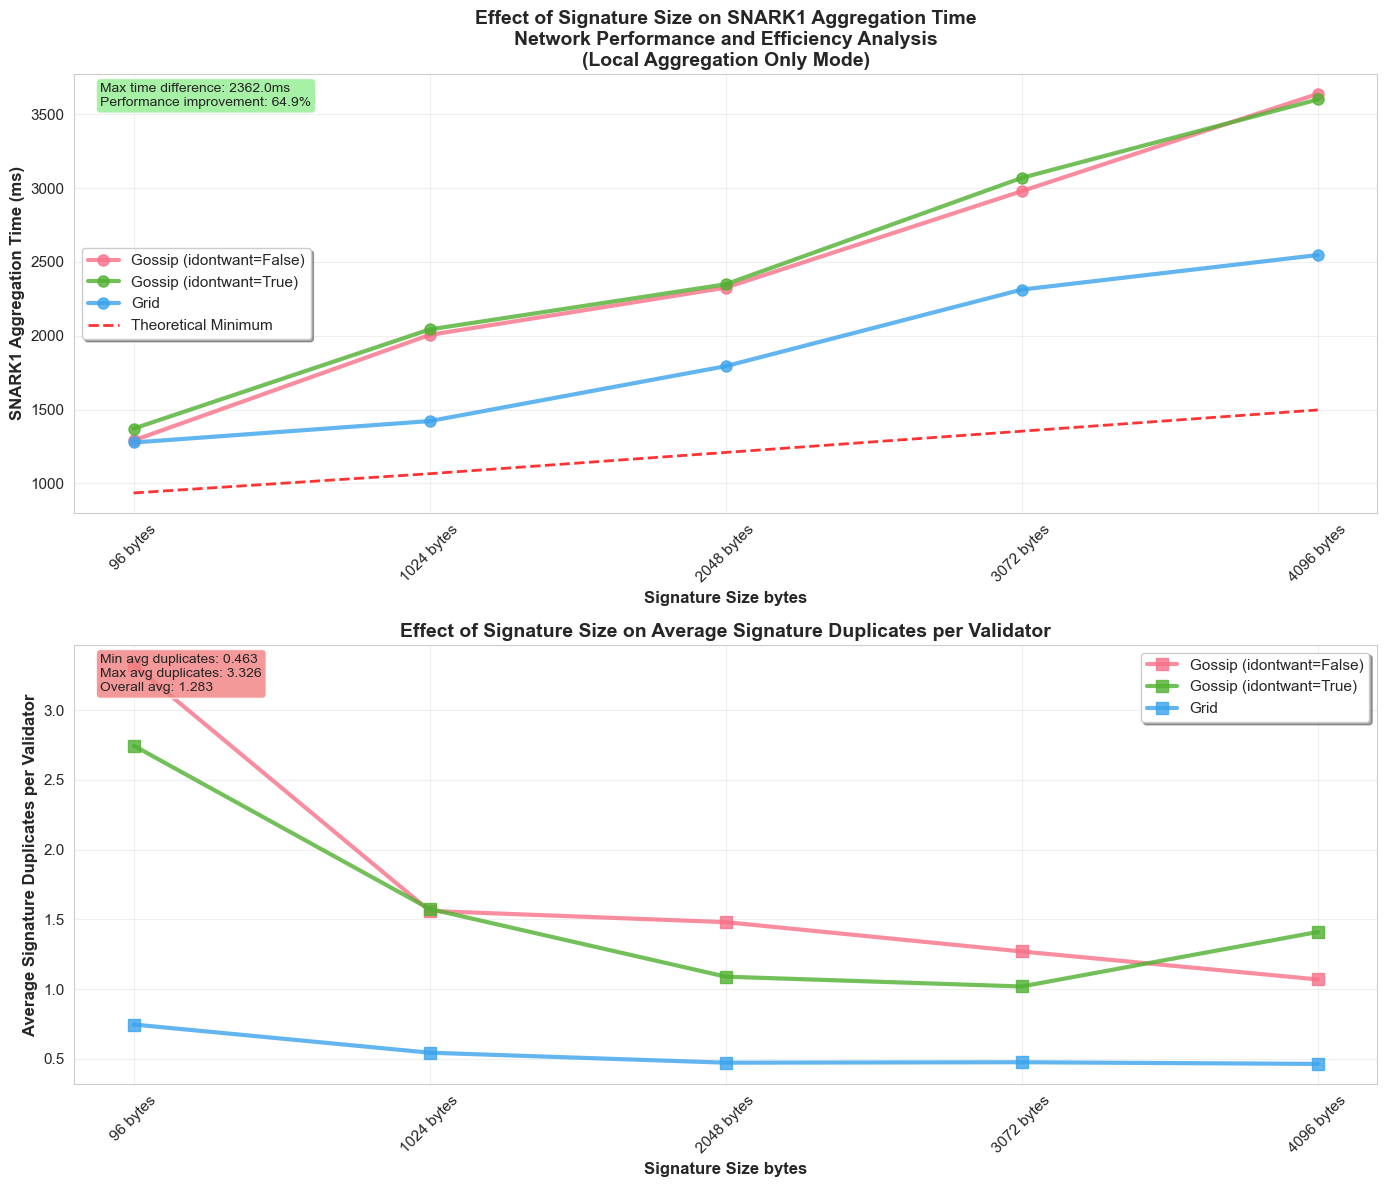


SIGNATURE SIZE EFFECT SUMMARY

Theoretical Minimum:
  SNARK1 time range: 935.1 - 1497.6 ms
  Time difference: 562.5 ms
        96 bytes: 935.1 ms
      1024 bytes: 1065.6 ms
      2048 bytes: 1209.6 ms
      3072 bytes: 1353.6 ms
      4096 bytes: 1497.6 ms

Gossip (idontwant=False):
  SNARK1 time range: 1291.0 - 3639.0 ms
  Time difference: 2348.0 ms
  Avg duplicates per validator range: 1.069 - 3.326
  Overall avg duplicates per validator: 1.741
  Total signature duplicates range: 991 - 3060 messages
        96 bytes: 1291.0 ms (avg dups: 3.326)
      1024 bytes: 2006.0 ms (avg dups: 1.561)
      2048 bytes: 2326.0 ms (avg dups: 1.480)
      3072 bytes: 2980.0 ms (avg dups: 1.270)
      4096 bytes: 3639.0 ms (avg dups: 1.069)

Gossip (idontwant=True):
  SNARK1 time range: 1371.0 - 3601.0 ms
  Time difference: 2230.0 ms
  Avg duplicates per validator range: 1.018 - 2.747
  Overall avg duplicates per validator: 1.568
  Total signature duplicates range: 937 - 2527 messages
        96 b

In [138]:
topologies = ["gossip", "grid"]

# Signature Size Analysis - Using the refactored approach
# This demonstrates how the new framework simplifies the analysis process

# Test different signature sizes to analyze their effect on SNARK1 aggregation time
signature_sizes = [
    96,      # 96 bytes - very small signature (BLS)
    1024,    # 1 KB - small signature
    2048,    # 2 KB - medium-small signature  
    3072,    # 3 KB - default signature size
    4096,    # 4 KB - medium signature
]

# Base configuration parameters
base_config = {
    'mpi': False,  # Use MPI for faster simulations
    # Add any other base parameters you want to override
}

# Test on both gossip and grid topologies
topologies = ["gossip", "grid"]

print("Analyzing the effect of signature size on SNARK1 aggregation time...")
print("Using the refactored analysis framework for cleaner code.\n")

# Run the signature size effect analysis using the new framework
results_df = analyze_signature_size_effect(signature_sizes, topologies, max_workers=5, idontwant=True, **base_config)


Analyzing the effect of max incoming bandwidth on SNARK1 aggregation time...
Testing Max Incoming Bandwidth: ['5Mbps', '25Mbps', '50Mbps', '100Mbps', '200Mbps']
Topologies: ['gossip', 'grid']
Running simulations in parallel with 5 workers (ThreadPoolExecutor)...

  [1/15] Gossip - 5Mbps (idontwant=False): 11678.0 ms
  [2/15] Gossip - 25Mbps (idontwant=True): 4722.0 ms
  [3/15] Gossip - 25Mbps (idontwant=False): 4605.0 ms
  [4/15] Gossip - 5Mbps (idontwant=True): 12496.0 ms
  [5/15] Gossip - 50Mbps (idontwant=False): 2980.0 ms
  [6/15] Gossip - 50Mbps (idontwant=True): 3070.0 ms
  [7/15] Gossip - 100Mbps (idontwant=True): 2441.0 ms
  [8/15] Gossip - 200Mbps (idontwant=False): 2306.0 ms
  [9/15] Gossip - 200Mbps (idontwant=True): 2336.0 ms
  [10/15] Grid - 25Mbps: 2838.0 ms
  [11/15] Grid - 100Mbps: 1830.0 ms
  [12/15] Grid - 5Mbps: 9055.0 ms
  [13/15] Grid - 50Mbps: 2313.0 ms
  [14/15] Gossip - 100Mbps (idontwant=False): 2404.0 ms
  [15/15] Grid - 200Mbps: 1394.0 ms
  [8/15] Gossip - 2

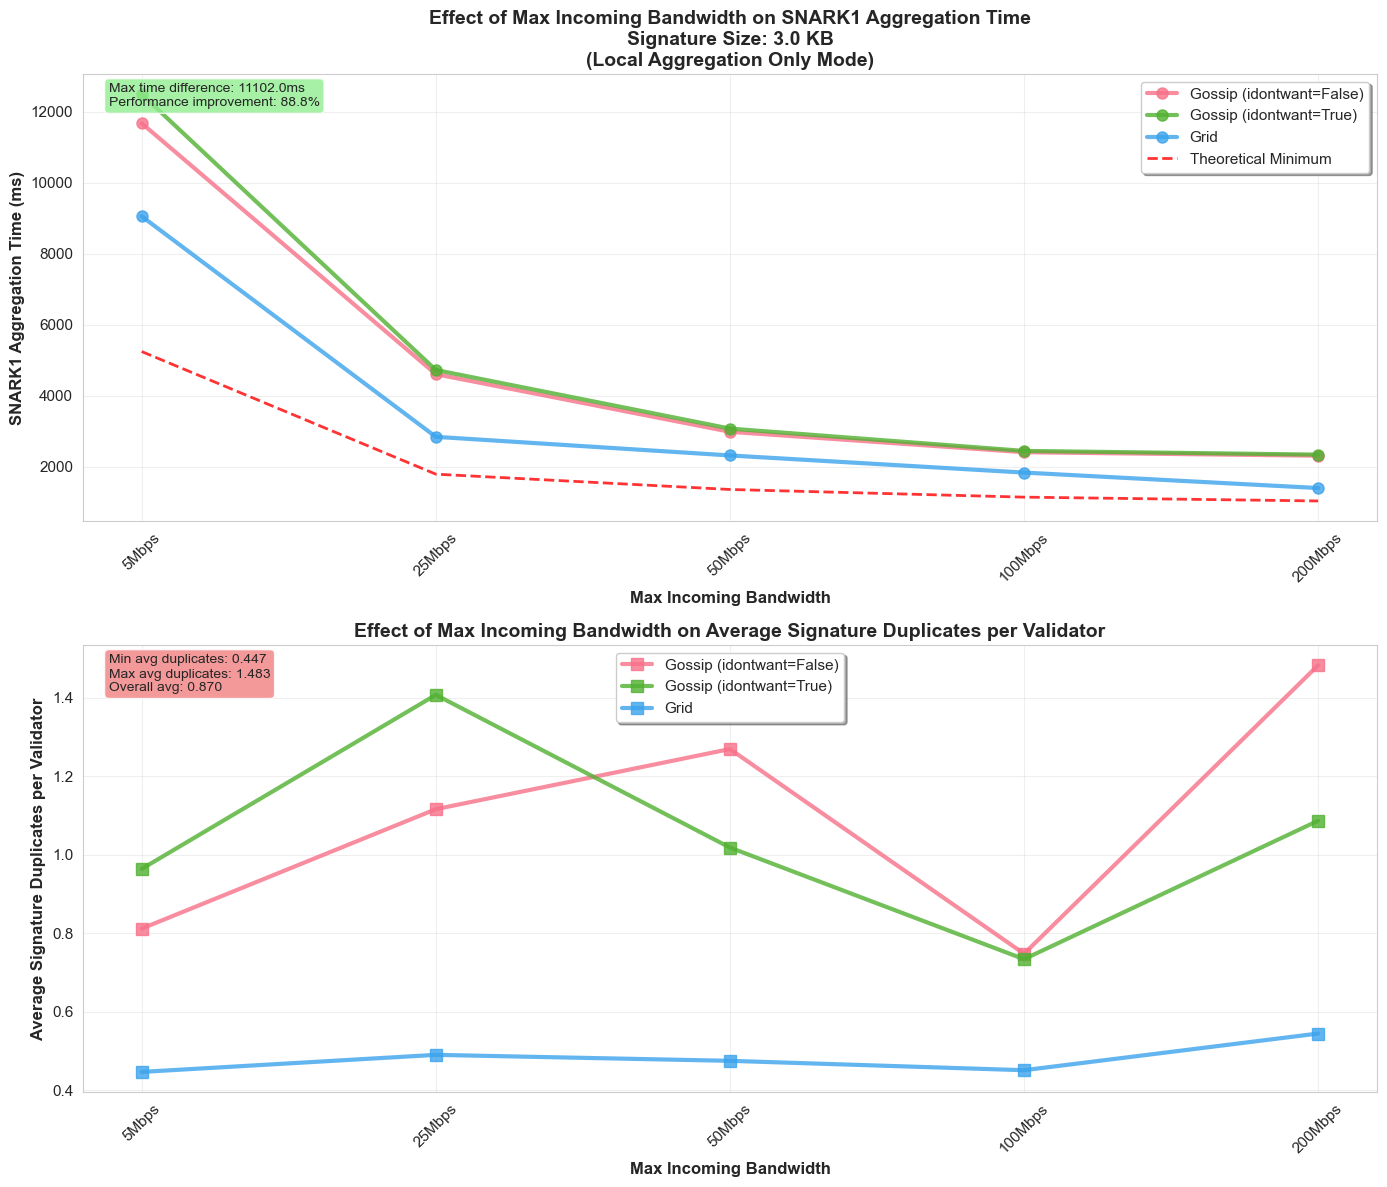


MAX INCOMING BANDWIDTH EFFECT SUMMARY

Theoretical Minimum:
  SNARK1 time range: 1029.6 - 5241.6 ms
  Time difference: 4212.0 ms
           5Mbps: 5241.6 ms
          25Mbps: 1785.6 ms
          50Mbps: 1353.6 ms
         100Mbps: 1137.6 ms
         200Mbps: 1029.6 ms

Gossip (idontwant=False):
  SNARK1 time range: 2306.0 - 11678.0 ms
  Time difference: 9372.0 ms
  Avg duplicates per validator range: 0.748 - 1.483
  Overall avg duplicates per validator: 1.086
  Total signature duplicates range: 688 - 1366 messages
           5Mbps: 11678.0 ms (avg dups: 0.812)
          25Mbps: 4605.0 ms (avg dups: 1.116)
          50Mbps: 2980.0 ms (avg dups: 1.270)
         100Mbps: 2404.0 ms (avg dups: 0.748)
         200Mbps: 2306.0 ms (avg dups: 1.483)

Gossip (idontwant=True):
  SNARK1 time range: 2336.0 - 12496.0 ms
  Time difference: 10160.0 ms
  Avg duplicates per validator range: 0.734 - 1.408
  Overall avg duplicates per validator: 1.042
  Total signature duplicates range: 679 - 1295 messag

In [ ]:
# Analyze bandwidth limits
bandwidth_limits = [5, 25, 50, 100, 200]
print("\nAnalyzing the effect of max incoming bandwidth on SNARK1 aggregation time...")
bandwidth_results = analyze_bandwidth_effect(
    bandwidth_limits, signature_size=3072, topologies=topologies,
    max_workers=5, idontwant=True, **base_config
)

EXAMPLE 1: Mesh N Analysis
Testing Mesh N: [4, 6, 8, 10, 12]
Topologies: ['gossip']
Running simulations in parallel with 5 workers (ThreadPoolExecutor)...

run: build/beamsim -c /var/folders/r9/53ggp_3x6w51pqj8_kv1_lb00000gn/T/beamsim-yaml-md5/5c14aaf4d379d3b8c1b929ea1a146659 -t gossip --local-aggregation-only --report
run: build/beamsim -c /var/folders/r9/53ggp_3x6w51pqj8_kv1_lb00000gn/T/beamsim-yaml-md5/f3143095f5456f43f6e0cc632a9f631d -t gossip --local-aggregation-only --report
run: build/beamsim -c /var/folders/r9/53ggp_3x6w51pqj8_kv1_lb00000gn/T/beamsim-yaml-md5/25cc047137e50092758e8806e1c69458 -t gossip --local-aggregation-only --report
run: build/beamsim -c /var/folders/r9/53ggp_3x6w51pqj8_kv1_lb00000gn/T/beamsim-yaml-md5/5f78b2d65ae2d4dc1e47774a76d64db3 -t gossip --local-aggregation-only --report
  [1/10] Gossip - 8 peers (idontwant=True): 3070.0 ms
  [2/10] Gossip - 8 peers (idontwant=False): 2980.0 ms
run: build/beamsim -c /var/folders/r9/53ggp_3x6w51pqj8_kv1_lb00000gn/T/beam

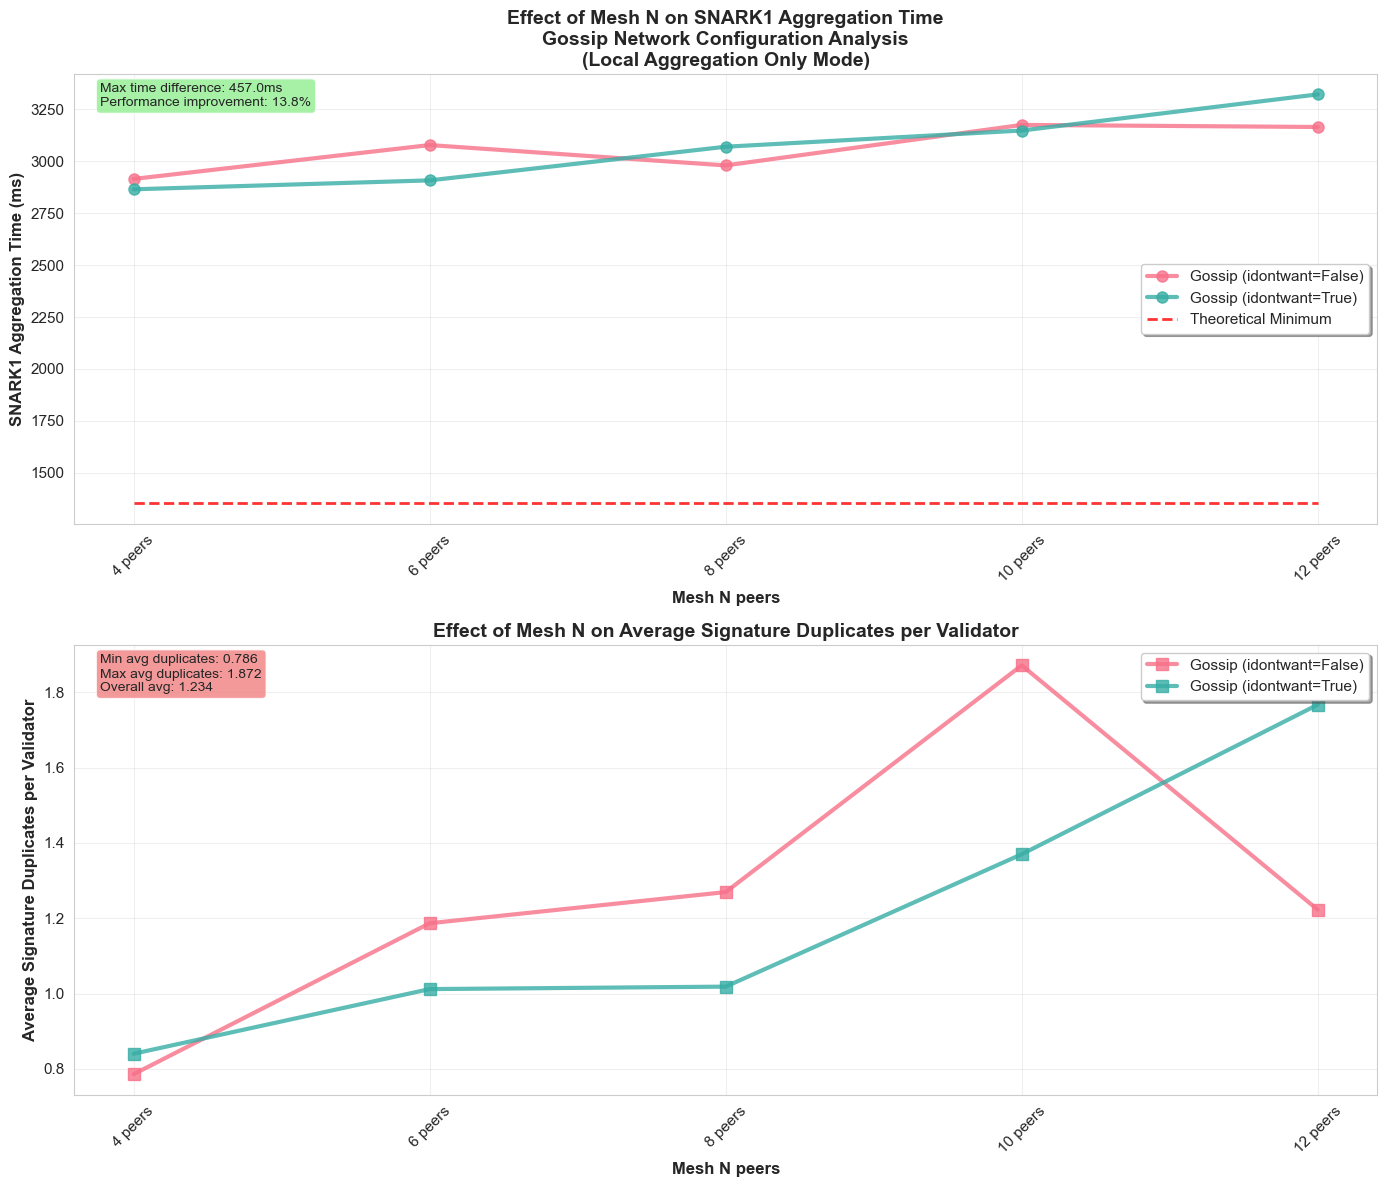


MESH N EFFECT SUMMARY

Theoretical Minimum:
  SNARK1 time range: 1353.6 - 1353.6 ms
  Time difference: 0.0 ms
         4 peers: 1353.6 ms
         6 peers: 1353.6 ms
         8 peers: 1353.6 ms
        10 peers: 1353.6 ms
        12 peers: 1353.6 ms

Gossip (idontwant=False):
  SNARK1 time range: 2915.0 - 3175.0 ms
  Time difference: 260.0 ms
  Avg duplicates per validator range: 0.786 - 1.872
  Overall avg duplicates per validator: 1.267
  Total signature duplicates range: 723 - 1767 messages
         4 peers: 2915.0 ms (avg dups: 0.786)
         6 peers: 3078.0 ms (avg dups: 1.187)
         8 peers: 2980.0 ms (avg dups: 1.270)
        10 peers: 3175.0 ms (avg dups: 1.872)
        12 peers: 3165.0 ms (avg dups: 1.223)

Gossip (idontwant=True):
  SNARK1 time range: 2865.0 - 3322.0 ms
  Time difference: 457.0 ms
  Avg duplicates per validator range: 0.840 - 1.767
  Overall avg duplicates per validator: 1.202
  Total signature duplicates range: 773 - 1626 messages
         4 peers: 2865

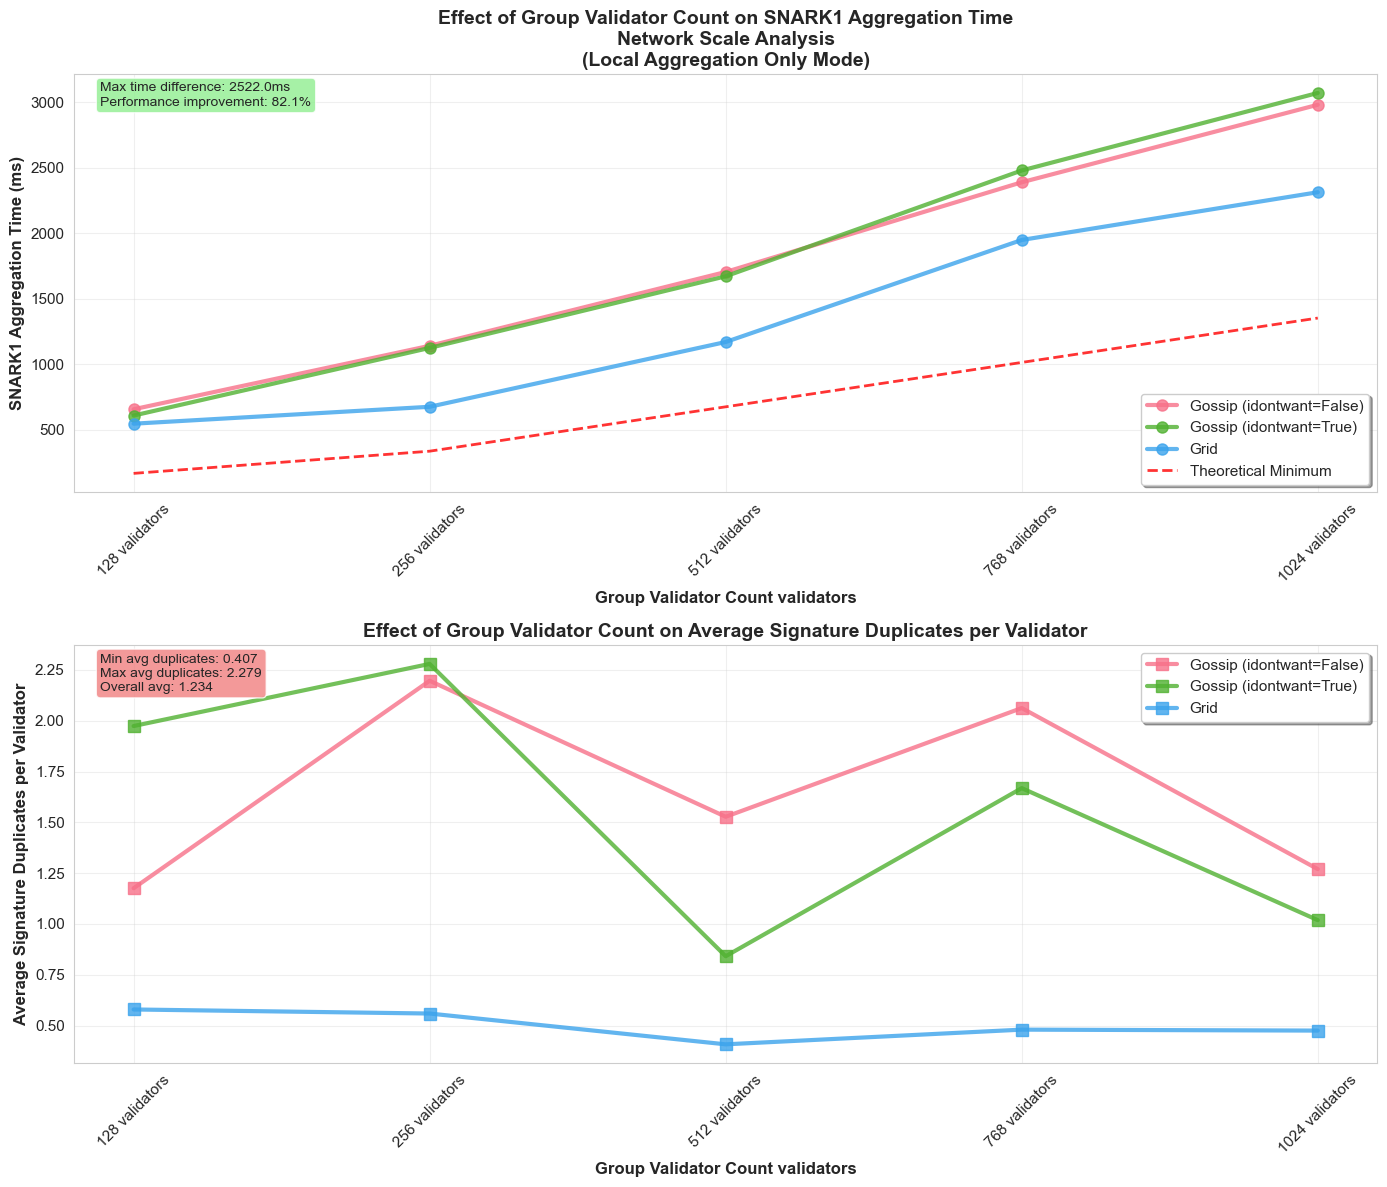


GROUP VALIDATOR COUNT EFFECT SUMMARY

Theoretical Minimum:
  SNARK1 time range: 169.2 - 1353.6 ms
  Time difference: 1184.4 ms
    128 validators: 169.2 ms
    256 validators: 338.4 ms
    512 validators: 676.8 ms
    768 validators: 1015.2 ms
    1024 validators: 1353.6 ms

Gossip (idontwant=False):
  SNARK1 time range: 658.0 - 2980.0 ms
  Time difference: 2322.0 ms
  Avg duplicates per validator range: 1.175 - 2.197
  Overall avg duplicates per validator: 1.646
  Total signature duplicates range: 134 - 1423 messages
    128 validators: 658.0 ms (avg dups: 1.175)
    256 validators: 1142.0 ms (avg dups: 2.197)
    512 validators: 1705.0 ms (avg dups: 1.527)
    768 validators: 2389.0 ms (avg dups: 2.062)
    1024 validators: 2980.0 ms (avg dups: 1.270)

Gossip (idontwant=True):
  SNARK1 time range: 610.0 - 3070.0 ms
  Time difference: 2460.0 ms
  Avg duplicates per validator range: 0.841 - 2.279
  Overall avg duplicates per validator: 1.556
  Total signature duplicates range: 225 - 1

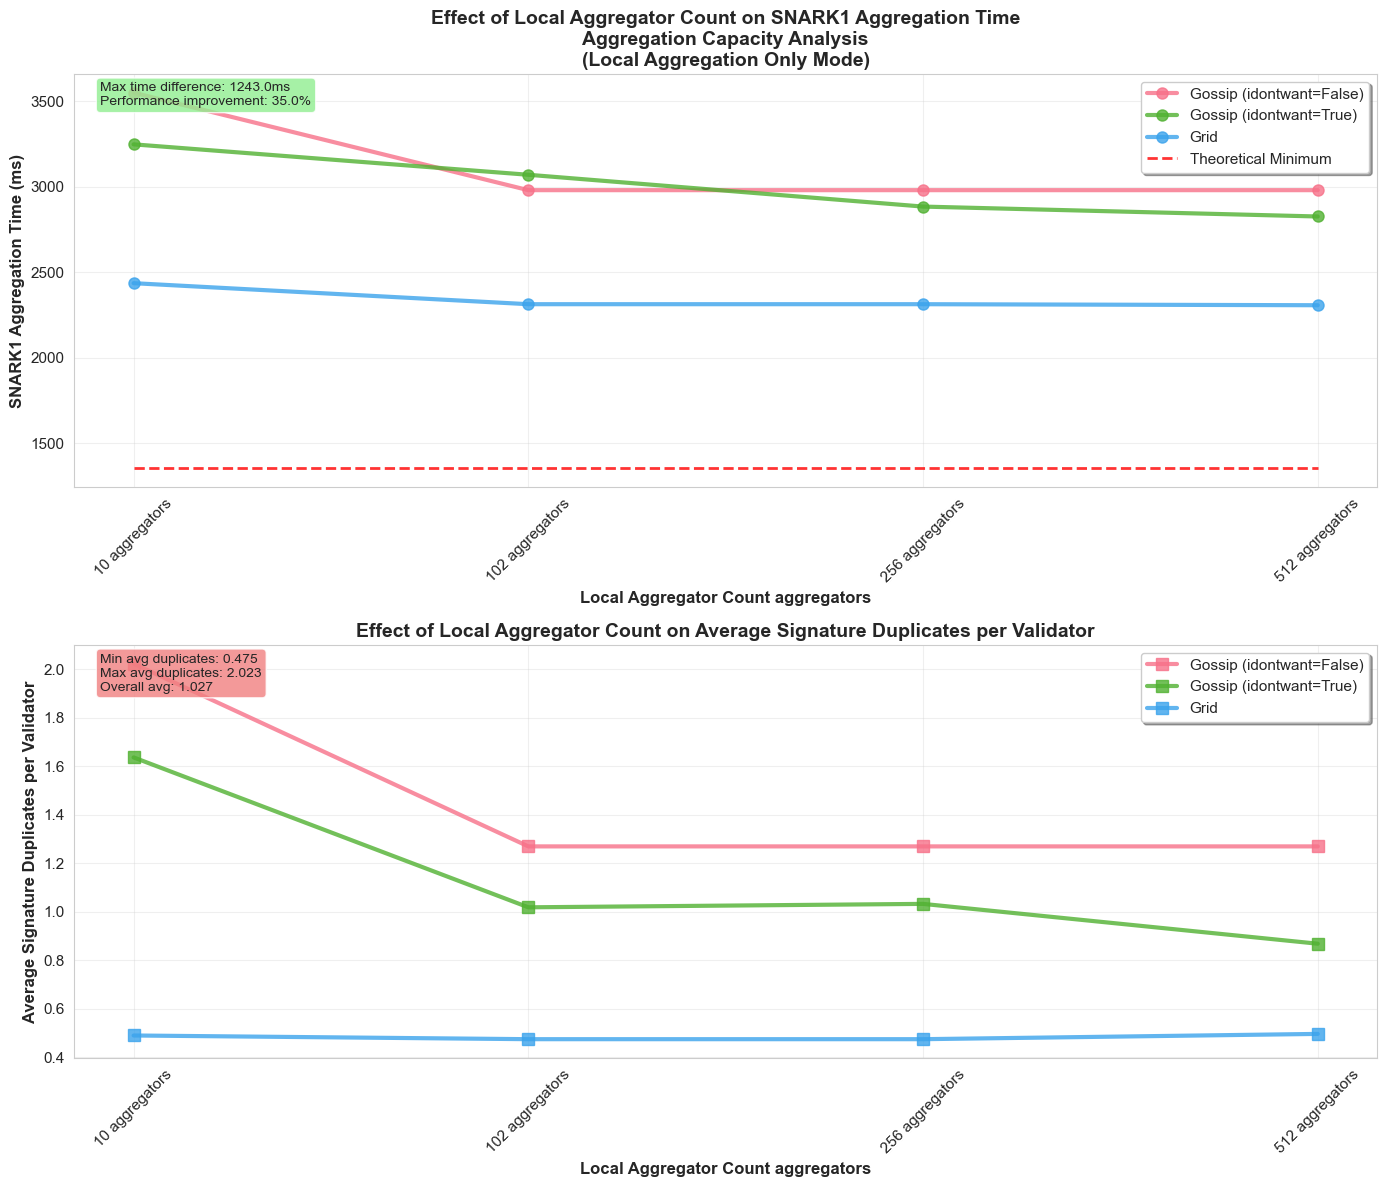


LOCAL AGGREGATOR COUNT EFFECT SUMMARY

Theoretical Minimum:
  SNARK1 time range: 1353.6 - 1353.6 ms
  Time difference: 0.0 ms
    10 aggregators: 1353.6 ms
    102 aggregators: 1353.6 ms
    256 aggregators: 1353.6 ms
    512 aggregators: 1353.6 ms

Gossip (idontwant=False):
  SNARK1 time range: 2980.0 - 3550.0 ms
  Time difference: 570.0 ms
  Avg duplicates per validator range: 1.270 - 2.023
  Overall avg duplicates per validator: 1.458
  Total signature duplicates range: 1168 - 1875 messages
    10 aggregators: 3550.0 ms (avg dups: 2.023)
    102 aggregators: 2980.0 ms (avg dups: 1.270)
    256 aggregators: 2980.0 ms (avg dups: 1.270)
    512 aggregators: 2980.0 ms (avg dups: 1.270)

Gossip (idontwant=True):
  SNARK1 time range: 2826.0 - 3248.0 ms
  Time difference: 422.0 ms
  Avg duplicates per validator range: 0.868 - 1.636
  Overall avg duplicates per validator: 1.139
  Total signature duplicates range: 799 - 1507 messages
    10 aggregators: 3248.0 ms (avg dups: 1.636)
    102 a

In [140]:
# Example analyses for new parameters using the refactored framework
# These demonstrate how easy it is to analyze different parameters

# Example 1: Analyze mesh_n effect (gossip network mesh size)
print("="*60)
print("EXAMPLE 1: Mesh N Analysis")
print("="*60)

mesh_n_values = [4, 6, 8, 10, 12]  # Different mesh sizes
base_config = {'mpi': False, 'signature_size': 3072}

mesh_n_results = analyze_mesh_n_effect(mesh_n_values, topologies=["gossip"], max_workers=5, idontwant=True, **base_config)


# Example 2: Analyze non_mesh_n effect (gossip non-mesh connections)
# print("\n" + "="*60)
# print("EXAMPLE 2: Non-Mesh N Analysis")
# print("="*60)

# non_mesh_n_values = [2, 4, 6, 8, 10]  # Different non-mesh connection counts
# base_config = {'mpi': False, 'signature_size': 3072}

# non_mesh_n_results = analyze_non_mesh_n_effect(non_mesh_n_values, topologies=["gossip"], max_workers=5, **base_config)


# Example 3: Analyze group_validator_count effect (network scale)
print("\n" + "="*60)
print("EXAMPLE 3: Group Validator Count Analysis")
print("="*60)

validator_counts = [128, 256, 512, 768, 1024]  # Different validator counts per group
base_config = {'mpi': False, 'signature_size': 3072}

validator_count_results = analyze_group_validator_count_effect(validator_counts, topologies=["gossip", "grid"], idontwant=True, **base_config)


# Example 4: Analyze local aggregator count effect
print("\n" + "="*60)
print("EXAMPLE 4: Local Aggregator Count Analysis")
print("="*60)

aggregator_counts = [10, 102, 256, 512]  # Different local aggregator counts
base_config = {'mpi': False, 'signature_size': 3072}

aggregator_count_results = analyze_local_aggregator_count_effect(aggregator_counts, topologies=["gossip", "grid"], max_workers=5, idontwant=True, **base_config)